# Import Libraries

Imports necessary libraries such as Pandas for data handling, NumPy for numerical operations, Matplotlib and Seaborn for visualization, MLxtend for association rule mining, and defaultdict for handling default dictionaries.

In [1]:
%pip install wordCloud

# Import necessary libraries
import pandas as pd                 # For data manipulation and analysis
import numpy as np                  # For numerical operations
import matplotlib.pyplot as plt     # For creating plots
import seaborn as sns               # For enhanced data visualization
import re                           # re (regular expression) is used for pattern matching with strings, enabling text search and manipulation.
from mlxtend.frequent_patterns import apriori, association_rules  # For Apriori algorithm and association rules
from mlxtend.preprocessing import TransactionEncoder
from matplotlib import colors
from collections import defaultdict  # For handling default dictionaries
from collections import Counter     # Counter is used to count hashable objects, like elements in a list.
from wordcloud import WordCloud     # A library used for generating word clouds from text data.
import pandas as pd
import sqlite3
from scipy.stats import linregress



Note: you may need to restart the kernel to use updated packages.


# EXTRACT

Loading several datasets related to anime information and user interactions from CSV files. Each dataset serves a specific purpose in analyzing anime preferences and user behaviors.

In [2]:
# Load datasets from CSV files
anime_info = pd.read_csv('./anime.csv')                     # Anime information dataset
anime_with_synopsis = pd.read_csv('./anime_with_synopsis.csv')  # Anime with synopsis dataset
user_ratings = pd.read_csv('./animelist.csv')               # User ratings dataset
rating_complete = pd.read_csv('./rating_complete.csv')      # Complete ratings dataset
watching_status = pd.read_csv('./watching_status.csv')      # Watching status dataset

# TRANSFORM

**PRE-PROCESSING FOR SYNOPSIS ANALYSIS**

Preparing a cleaned DataFrame (cleaned_anime_df) that combines essential information from two data sources (anime_with_synopsis and anime_info). Initially, we filter and select columns of interest from anime_with_synopsis, focusing on 'MAL_ID', 'Name', 'Genres', and 'sypnopsis' (typo corrected to 'Synopsis'). Next, we merge this filtered DataFrame (synopsis_info_df) with anime_info based on the shared 'MAL_ID'. After merging, we further refine the DataFrame by selecting specific columns ('Name_synopsis', 'Genres_synopsis', 'sypnopsis', 'Type', 'Score', 'no_of_scores'), which we rename for clarity. This final DataFrame (cleaned_anime_df) is structured to provide a consolidated view of anime data, including title, genres, synopsis, type, score, and number of scores.

In [3]:
# Data Cleaning and Transformation Part

# Replace 'Unknown' values with 0 in score columns
anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']] = \
    anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']].replace('Unknown', 0)

# Change datatype of score columns to numeric
anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']] = \
    anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']].apply(pd.to_numeric)

# Calculate total number of scores for each anime
anime_info['no_of_scores'] = anime_info['Score-10'] + anime_info['Score-9'] + anime_info['Score-8'] + \
                             anime_info['Score-7'] + anime_info['Score-6'] + anime_info['Score-5'] + \
                             anime_info['Score-4'] + anime_info['Score-3'] + anime_info['Score-2'] + \
                             anime_info['Score-1']

In [4]:
# Filter relevant columns from anime_with_synopsis DataFrame
synopsis_info_df = anime_with_synopsis[['MAL_ID', 'Name', 'Genres', 'sypnopsis']]

# Merge anime_info with synopsis_info_df on 'MAL_ID' to combine detailed information
merged_anime_df = synopsis_info_df.join(anime_info.set_index('MAL_ID'), on='MAL_ID', lsuffix='_synopsis', rsuffix='_info')

# Select specific columns for clarity and rename them
cleaned_anime_df = merged_anime_df[['Name_synopsis', 'Genres_synopsis', 'sypnopsis', 'Type', 'Score', 'no_of_scores']]
cleaned_anime_df.columns = ['Name', 'Genres', 'Synopsis', 'Type', 'Score', 'No_of_Scores']

# Display the cleaned DataFrame
cleaned_anime_df.head()


,Name,Genres,Synopsis,Type,Score,No_of_Scores
0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",TV,8.78,641705.0
1,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",Movie,8.39,160349.0
2,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",TV,8.24,286146.0
3,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,TV,7.27,39094.0
4,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,TV,6.98,5923.0


Designed to prepare data for analysis of top 100 anime based on their scores. Initially, we clean and preprocess score data, replacing 'Unknown' values with zeros and converting columns to numeric types. Next, we calculate the total number of scores for each anime. We then extract the top 100 anime based on highest scores and merge this data with detailed information including synopses. Using an expanded list of stop words, we filter out common words from the synopses and tokenize them to analyze the most frequently used words. Finally, we display the top 20 most common words found in the combined synopses of the top 100 anime.

In [6]:
# Get the anime with synopsis
anime_synop_df = anime_with_synopsis[['MAL_ID', 'Name', 'Genres', 'sypnopsis']]
anime_df = anime_synop_df.join(anime_info, on='MAL_ID', rsuffix='r')
anime_df = anime_df[['Name', 'Genres', 'sypnopsis', 'Type']]
anime_df.columns = ['Name', 'Genres', 'Synopsis', 'Type']

# Replace 'Unknown' values with 0 in score columns
anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']] = \
    anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']].replace('Unknown', 0)

# Change datatype of score columns to numeric
anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']] = \
    anime_info[['Score', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']].apply(pd.to_numeric)

# Calculate total number of scores for each anime
anime_info['no_of_scores'] = anime_info['Score-10'] + anime_info['Score-9'] + anime_info['Score-8'] + \
                             anime_info['Score-7'] + anime_info['Score-6'] + anime_info['Score-5'] + \
                             anime_info['Score-4'] + anime_info['Score-3'] + anime_info['Score-2'] + \
                             anime_info['Score-1']

# Extract top 100 anime based on highest scores
top100_anime = anime_info.sort_values('Score', ascending=False).iloc[:100]

# Merge top100_anime with cleaned_anime_df to get synopsis
top100_anime_with_synopsis_df = top100_anime.merge(cleaned_anime_df[['Name', 'Synopsis']], on='Name', how='left')
# Merge top100_anime with anime_df to get synopsis
top100_animeb = anime_info.sort_values('Score', ascending=False).iloc[:100]
top100_anime_df = top100_animeb.merge(anime_df[['Name', 'Synopsis']], on='Name', how='left')

# Expanded list of stop words
stop_words = set([
    "and", "or", "but", "if", "while", "though", "although", "because", "since", "unless", "until", "whereas", 
    "either", "neither", "nor", "so", "than", "that", "once", "after", "before", "when", "whenever", "where", 
    "wherever", "why", "as", "even", "now", "whether", "for", "with", "without", "within", "against", "during", 
    "on", "upon", "in", "out", "at", "by", "through", "between", "about", "over", "under", "above", "below", 
    "from", "to", "into", "of", "off", "again", "further", "then", "here", "there", "each", "few", "some", 
    "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "can", "will", "just", 
    "don", "should", "now", "oh", "ah", "ouch", "wow", "hey", "alas", "oh", "well", "hmm", "uh", "um", "er", 
    "huh", "aha", "gee", "oops", "ow", "their", "they", "who", "be", "it", "however", "this", "these", "those",
    "he", "she", "him", "her", "his", "hers", "its", "our", "ours", "your", "yours", "their", "theirs", "the", 
    "a", "is", "s", "an","has","an","are","them","have", "what", "where","when","who","how"
])

# Tokenize and count words in the synopsis
def tokenize(text):
    text = text.lower()  # Convert to lowercase
    words = re.findall(r'\b\w+\b', text)  # Extract words using regex
    filtered_words = [word for word in words if word not in stop_words]  # Remove stop words
    return filtered_words

# Combine all synopsis into one string
combined_synopsis = " ".join(top100_anime_with_synopsis_df['Synopsis'].dropna())

# Tokenize the combined synopsis
words = tokenize(combined_synopsis)

# Get the most common words
word_counts = Counter(words)
common_words = word_counts.most_common()

# Display the most common words
common_words[:20]


[('one', 45),
 ('all', 44),
 ('life', 43),
 ('world', 41),
 ('new', 35),
 ('school', 34),
 ('two', 30),
 ('more', 30),
 ('high', 30),
 ('time', 27),
 ('friends', 26),
 ('must', 25),
 ('gintoki', 25),
 ('himself', 22),
 ('team', 21),
 ('war', 21),
 ('natsume', 21),
 ('young', 20),
 ('old', 20),
 ('mysterious', 20)]

____________________________________________________________________________________________________________________________________________________________

**PRE-PROCESSING FOR GENRE AND DROP RATE ANALYSIS (APRIORI)** 

In this analysis, we explore the relationship between anime genres and viewer drop rates using **association rule mining techniques**. The dataset contains extensive information on anime genres and user behaviors, particularly focusing on how genre preferences may influence the likelihood of an anime being dropped by viewers.

In [19]:
# Select relevant columns and handle missing values
ap_df = anime_info[['Genres', 'Dropped']].copy()
ap_df.dropna(subset=['Genres'], inplace=True)


# Remove non-numerical values in the dropped column
ap_df['Dropped'] = pd.to_numeric(ap_df['Dropped'], errors='coerce')

For the apriori algorithm, we need to transform the "dropped" column from a continuous variable into a categorical one. To do this, we need to set a threshold to differentiate frequently dropped and less frequently dropped animes. To find the right threshold, let's look at the distribution of drop rates.

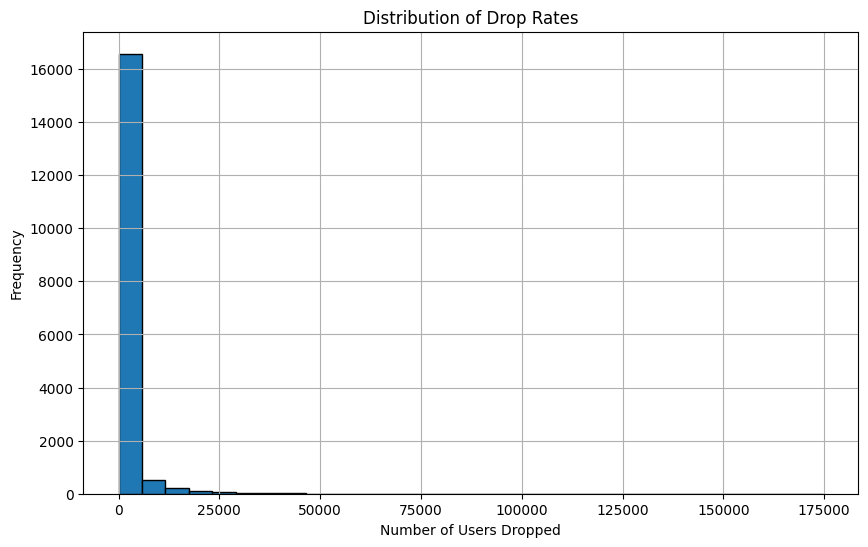

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(ap_df['Dropped'], bins=30, edgecolor='black')
plt.xlabel('Number of Users Dropped')
plt.ylabel('Frequency')
plt.title('Distribution of Drop Rates')
plt.grid(True)
plt.show()

Since the graph is Left-skewed distributions, it means that the bulk of the data (anime) have low drop rates, and only a small proportion have high drop rates. Because is heavily-skewed, we need to pick a higher percentile like 80th percentile, which means that 80% of the anime would then be categorized  as "frequently dropped".

In [21]:
# Calculate and print the 75th percentile
percentile_80 = np.percentile(ap_df['Dropped'], 80)
print(f'80th Percentile of Drop Rates: {percentile_80}')

# Create a binary variable for dropped (e.g., less than 424 dropped is considered not frequently dropped)
threshold = percentile_80
ap_df['Dropped_Binary'] = ap_df['Dropped'].apply(lambda x: 'Dropped=No' if x <= threshold else 'Dropped=Yes')
ap_df

80th Percentile of Drop Rates: 424.0


,Genres,Dropped,Dropped_Binary
0,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26678,Dropped=Yes
1,"Action, Drama, Mystery, Sci-Fi, Space",770,Dropped=Yes
2,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",13925,Dropped=Yes
3,"Action, Mystery, Police, Supernatural, Drama, ...",5378,Dropped=Yes
4,"Adventure, Fantasy, Shounen, Supernatural",1108,Dropped=Yes
...,...,...,...
17557,"Adventure, Mystery, Supernatural",0,Dropped=No
17558,"Comedy, Horror, Supernatural",0,Dropped=No
17559,"Mystery, Dementia, Horror, Psychological, Supe...",0,Dropped=No
17560,"Adventure, Slice of Life, Comedy",1,Dropped=No


____________________________________________________________________________________________________________________________________________________________

**PREPROCESSING FOR FREQUENT ANIME SEQUENCES ANALYSIS**

In this analysis, the goal is to filter and organize data for users and anime, preparing it for sequential pattern mining. The cell below is for preprocessing data to analyze frequent anime sequences watched by users. 


The code preprocesses the data by selecting the first 1000 unique users from the **user_ratings** DataFrame and filtering the data to include only their records. It then sorts this filtered data by user ID and anime ID to maintain the sequence of watched anime. Finally, it merges the filtered data with the **anime_info** DataFrame to add anime names, resulting in a clean dataset ready for analyzing frequent anime sequences.

In [30]:
# Get the first 100 unique users
unique_users = user_ratings['user_id'].unique()[:1000]

# Filter the dataframe to include only these users
df_filtered = user_ratings[user_ratings['user_id'].isin(unique_users)]

# Sort the dataframe by user_id and anime_id to maintain watching order
df_filtered = df_filtered.sort_values(['user_id', 'anime_id'])

# Merge with anime names
df_filtered = df_filtered.merge(anime_info[['MAL_ID', 'Name']], left_on='anime_id', right_on='MAL_ID')

df_filtered

,user_id,anime_id,rating,watching_status,watched_episodes,MAL_ID,Name
0,0,19,0,6,0,19,Monster
1,0,20,0,2,220,20,Naruto
2,0,21,10,1,0,21,One Piece
3,0,24,9,1,5,24,School Rumble
4,0,67,9,1,1,67,Basilisk: Kouga Ninpou Chou
...,...,...,...,...,...,...,...
346372,1089,3588,7,2,51,3588,Soul Eater
346373,1089,4196,8,2,12,4196,Ikkitousen: Great Guardians
346374,1089,4437,8,2,1,4437,Naruto: Shippuuden Movie 2 - Kizuna
346375,1089,4726,8,2,12,4726,Druaga no Tou: The Sword of Uruk


# LOADING

In [31]:

synopsis_df = pd.DataFrame(top100_anime_with_synopsis_df)
apriori_df = pd.DataFrame(ap_df)
sequence_df = pd.DataFrame(df_filtered)

#Connect to SQLite Database
conn = sqlite3.connect('cleaned_anime_data.db')

#Write DataFrames to SQLite Table
synopsis_df.to_sql('synopsis_df', conn, if_exists='replace', index=False)
apriori_df.to_sql('apriori_df', conn, if_exists='replace', index=False)
sequence_df.to_sql('sequence_df', conn, if_exists='replace', index=False)

#Close the Connection
conn.close()

## ANALYSIS


**Retrieving tranformed data from Database**

In [32]:
#Connect to SQLite Database
conn = sqlite3.connect('cleaned_anime_data.db')

# Load the three transfrormed dataframes  from SQLite database
query = "SELECT * FROM synopsis_df;"
top100_anime_with_synopsis_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM apriori_df;"
ap_df = pd.read_sql_query(query, conn)

query = "SELECT * FROM sequence_df;"
df_filtered = pd.read_sql_query(query, conn)

#Close the Connection
conn.close()

**Plot the Synopsis analysis Result**

This part generates a word cloud and bar plot showing the most common words in the synopses of the top 100 anime. It also calculates and displays the correlation between the occurrence of these common words and the number of scores received by each anime.



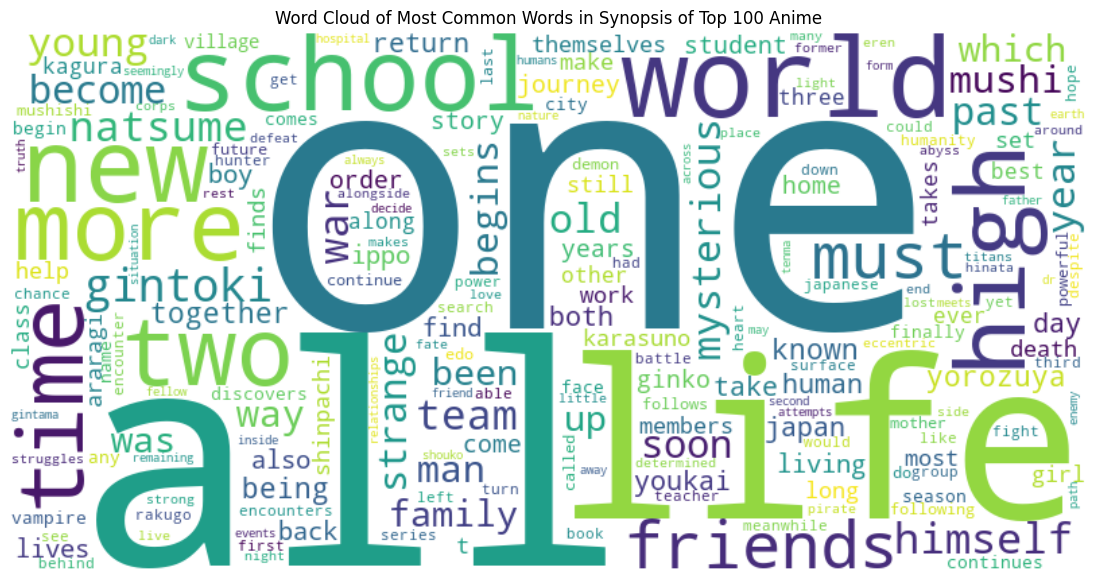

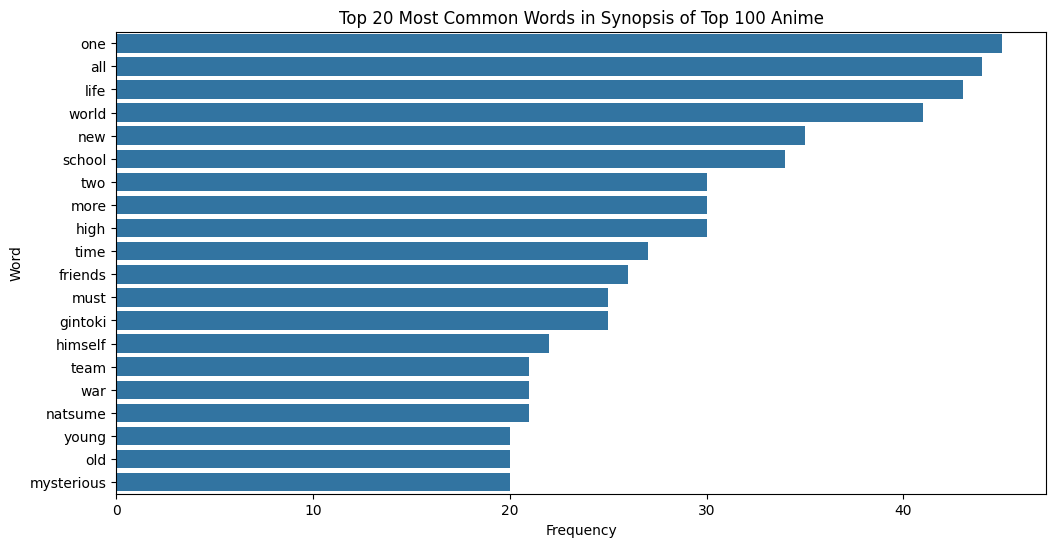


Correlation Matrix of Common Words in Synopsis and Number of Scores:
              no_of_scores       one       all      life     world       new  \
no_of_scores      1.000000  0.399262  0.278786  0.112308  0.149455  0.040269   
one               0.399262  1.000000  0.195755  0.236705  0.075117 -0.197285   
all               0.278786  0.195755  1.000000 -0.067155  0.207785  0.015516   
life              0.112308  0.236705 -0.067155  1.000000  0.162712 -0.181313   
world             0.149455  0.075117  0.207785  0.162712  1.000000 -0.035203   
new               0.040269 -0.197285  0.015516 -0.181313 -0.035203  1.000000   
school            0.221599  0.106514  0.305485  0.056930 -0.048933  0.009974   
two              -0.019255 -0.004779  0.293953  0.178792 -0.020841 -0.004799   
more             -0.005308 -0.017768  0.068300 -0.184152 -0.003689  0.045872   
high              0.220491  0.129744  0.234585  0.042464  0.042910  0.038108   
time              0.037414  0.098737 -0.014982  0.

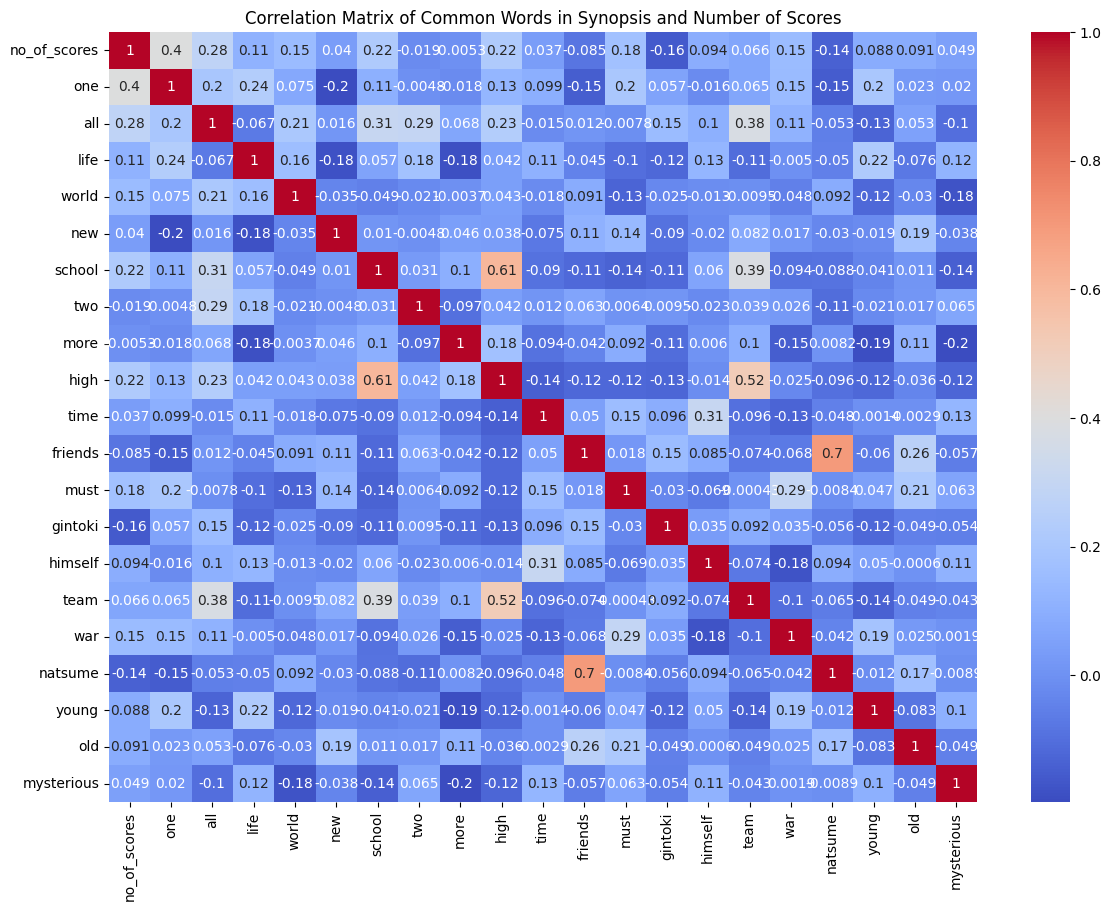

In [12]:


# Create a word cloud for the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Create a DataFrame for common words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Synopsis of Top 100 Anime')
plt.show()

# Plot the top 20 most common words as a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df.head(20))
plt.title('Top 20 Most Common Words in Synopsis of Top 100 Anime')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Function to count occurrences of a word in synopsis
def count_word_in_synopsis(word, synopsis):
    return synopsis.lower().count(word)

# Add columns for each common word to the DataFrame
for word, _ in common_words[:20]:
    top100_anime_with_synopsis_df[word] = top100_anime_with_synopsis_df['Synopsis'].apply(lambda x: count_word_in_synopsis(word, x) if pd.notna(x) else 0)

# Calculate correlation matrix between number of scores and common words in synopsis
correlation_matrix = top100_anime_with_synopsis_df[['no_of_scores'] + [word for word, _ in common_words[:20]]].corr()

# Display correlation matrix
print("\nCorrelation Matrix of Common Words in Synopsis and Number of Scores:")
print(correlation_matrix)

# Plot heatmap of correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Common Words in Synopsis and Number of Scores')
plt.show()

____________________________________________________________________________________________________________________________________________________________

**Anime Genre Analysis and Viewer Drop Rates**

This is part of the preprocess but not included since the database doesn't support lists

In [13]:
# Split genres into a list of individual genres
ap_df['Genres'] = ap_df['Genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

This code snippet processes anime data to identify associations between genres and anime drop rates using the Apriori algorithm. It begins by creating transactions where each consists of anime genres and whether they are frequently dropped. These transactions are then encoded into a DataFrame using one-hot encoding. The Apriori algorithm is applied to discover frequent itemsets based on a minimum support threshold. Association rules are generated and filtered to find those where anime is dropped, subsequently sorted by lift or confidence to highlight significant genre associations with higher drop rates. The final output displays these rules, providing insights into which genre combinations are most strongly associated with anime being dropped.

In [14]:

# Create transactions
transactions = []
for _, row in ap_df.iterrows():
    transaction = row['Genres']
    transaction.append(row['Dropped_Binary'])
    transactions.append(transaction)

# Create a DataFrame with one-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Filter rules for consequents where anime is dropped
dropped_rules = rules[rules['consequents'] == frozenset({'Dropped=Yes'})]

# Sort rules by lift or confidence to identify significant associations
dropped_rules = dropped_rules.sort_values(by='lift', ascending=False)

# Display the filtered and sorted rules
print(dropped_rules[['antecedents', 'support', 'confidence', 'lift']])



                       antecedents   support  confidence      lift
1114     (School, Romance, Comedy)  0.012470    0.669725  3.352824
842              (School, Romance)  0.018506    0.636008  3.184028
136                        (Harem)  0.013552    0.596491  2.986197
390         (Supernatural, Action)  0.017766    0.532423  2.665455
620              (Romance, Comedy)  0.028186    0.531686  2.661766
146                (Psychological)  0.010420    0.530435  2.655500
626               (School, Comedy)  0.028015    0.518987  2.598191
554                (Drama, Comedy)  0.016399    0.509735  2.551869
602                (Ecchi, Comedy)  0.015545    0.502762  2.516965
738               (Romance, Drama)  0.019474    0.500000  2.503136
818             (Romance, Fantasy)  0.010648    0.498667  2.496461
132                        (Ecchi)  0.021752    0.498044  2.493345
360                (Magic, Action)  0.011047    0.496164  2.483930
848        (School, Slice of Life)  0.012015    0.492991  2.46

**Interpretation of the Apriori Results**



Antecedents: (School, Comedy, Romance)
- This indicates a combination of anime genres that frequently appear together in the dataset.


Support (0.012470):
- This represents the proportion of transactions (anime) that contain the combination (School, Comedy, Romance).

Confidence (0.669725):
- This suggests that there is a 66.97% likelihood that an anime containing the genres (School, Comedy, Romance) will also be dropped.

Lift (3.352824):
- A lift of 3.35 suggests that anime featuring genres (School, Comedy, Romance) are significantly more likely to be dropped than would be expected if their occurrence were independent.


Conclusion:
The association rule (School, Comedy, Romance) -> Dropped=Yes indicates that anime characterized by genres such as school, comedy, and romance tend to have a relatively high likelihood of being dropped by users. This insight can guide content creators and platforms in understanding viewer preferences and potentially adjusting content strategies to improve viewer engagement and retention.

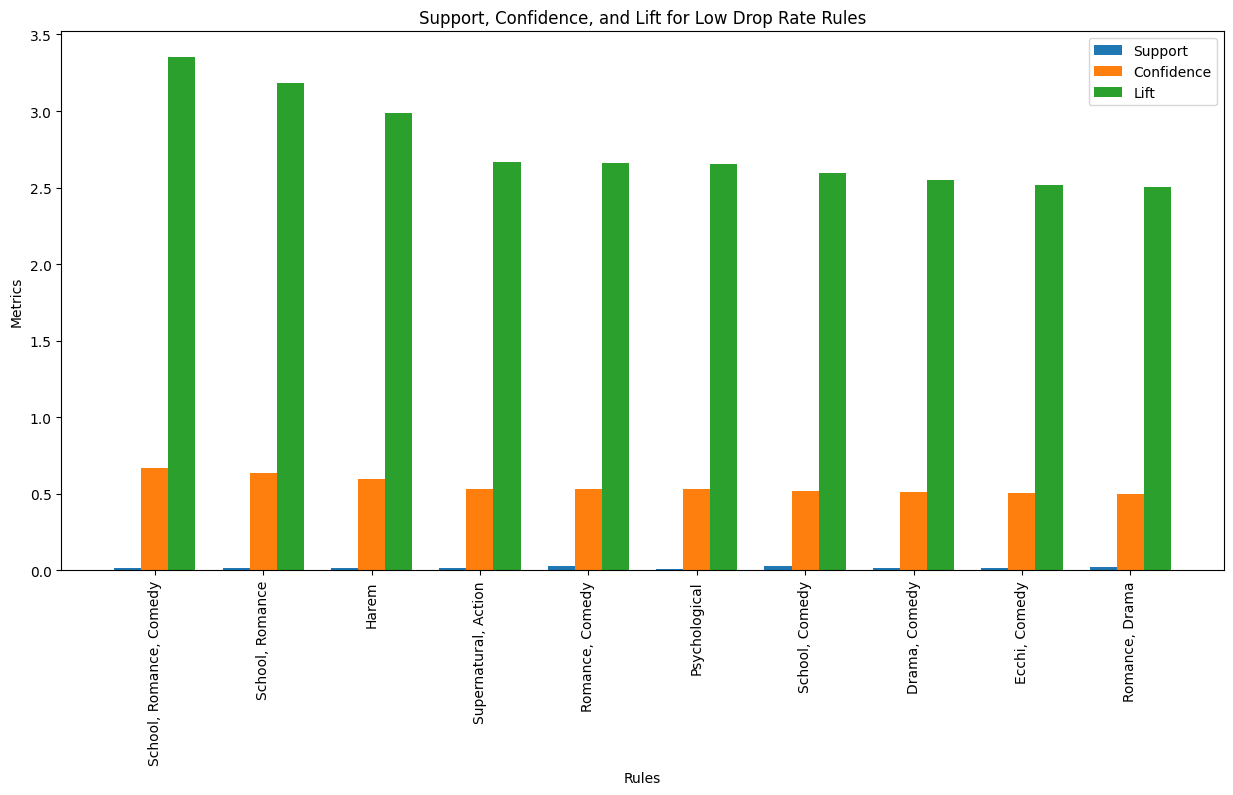

In [15]:
# Extract support, confidence, and lift for visualization
drop_rules_sorted =dropped_rules.sort_values(by='lift', ascending=False).head(10)
antecedents = drop_rules_sorted['antecedents'].apply(lambda x: ', '.join(list(x)))
support = drop_rules_sorted['support']
confidence = drop_rules_sorted['confidence']
lift = drop_rules_sorted['lift']

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
bar_width = 0.25

index = range(len(antecedents))

# Bar plot for support
ax.bar(index, support, bar_width, label='Support')

# Bar plot for confidence
ax.bar([i + bar_width for i in index], confidence, bar_width, label='Confidence')

# Bar plot for lift
ax.bar([i + bar_width * 2 for i in index], lift, bar_width, label='Lift')

ax.set_xlabel('Rules')
ax.set_ylabel('Metrics')
ax.set_title('Support, Confidence, and Lift for Low Drop Rate Rules')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(antecedents, rotation=90)
ax.legend()

plt.show()

____________________________________________________________________________________________________________________________________________________________

**Frequent Anime Sequence Analysis**

In this cell, the code creates a list of anime sequences watched by each user. It groups the df_filtered DataFrame by **user_id**, aggregates the anime names into lists for each user, and then converts these lists into a single list. 

In [34]:
# Create a list of anime sequences for each user
user_sequences = df_filtered.groupby('user_id')['Name'].apply(list).tolist()

print("User sequences (first 5 anime for each user):")
for seq in user_sequences:
    print(seq[:5])

User sequences (first 5 anime for each user):
['Monster', 'Naruto', 'One Piece', 'School Rumble', 'Basilisk: Kouga Ninpou Chou']
['Monster', 'Naruto', 'One Piece', 'Tennis no Ouji-sama', 'Shaman King']
['Eyeshield 21', 'Monster', 'Naruto', 'One Piece', 'Tennis no Ouji-sama']
['Cowboy Bebop', 'Initial D Fourth Stage', 'Sunabouzu', 'Neon Genesis Evangelion', 'Koukaku Kidoutai']
['Hachimitsu to Clover', 'Chobits', 'D.N.Angel', 'Black Cat (TV)', 'Full Metal Panic!']
['Hachimitsu to Clover', 'School Rumble', 'Chobits', 'Azumanga Daioh', 'Full Metal Panic!']
['Cowboy Bebop', 'Cowboy Bebop: Tengoku no Tobira', 'Trigun', 'Witch Hunter Robin', 'Monster']
['Aishiteruze Baby★★', 'Boys Be...', 'Kareshi Kanojo no Jijou', 'Kimi ga Nozomu Eien', 'Sen to Chihiro no Kamikakushi']
['Cowboy Bebop', 'Trinity Blood', 'Neon Genesis Evangelion', 'Neon Genesis Evangelion: Death & Rebirth', 'Fullmetal Alchemist']
['Kuroinu: Kedakaki Seijo wa Hakudaku ni Somaru', 'No Game No Life', 'Death Parade']
['Kidou Tensh

**OUTPUT**

The output shows the first five anime titles for each of the users. This provides a snapshot of the anime viewing sequences for the initial 1000 users, illustrating their watching patterns.



In the cell below, the function find_frequent_sequences identifies frequent anime sequences from user data. It calculates how often each sequence of a given length occurs and filters those with support above a specified threshold. The results are then converted to a DataFrame, sorted by support, and printed. 

In [35]:
def find_frequent_sequences(sequences, min_support, sequence_length):
    sequence_counts = {}
    total_sequences = len(sequences)
    
    for sequence in sequences:
        for i in range(len(sequence) - sequence_length + 1):
            seq = tuple(sequence[i:i+sequence_length])
            if seq in sequence_counts:
                sequence_counts[seq] += 1
            else:
                sequence_counts[seq] = 1
    
    # Compute support and filter by min_support
    frequent_sequences = {seq: (count, count / total_sequences) 
                          for seq, count in sequence_counts.items() 
                          if count / total_sequences >= min_support}
    
    return frequent_sequences

# Set minimum support and sequence length
min_support = 0.01  # 30% of users
sequence_length = 3  # sequences of 2 anime

# Find frequent sequences
frequent_sequences = find_frequent_sequences(user_sequences, min_support, sequence_length)

# Convert to DataFrame for easier viewing
frequent_sequences_df = pd.DataFrame([(seq, count, support) 
                                       for seq, (count, support) in frequent_sequences.items()],
                                      columns=['Anime Sequence', 'Count', 'Support'])
frequent_sequences_df = frequent_sequences_df.sort_values('Support', ascending=False)

# Print DataFrame without index numbers
print(frequent_sequences_df.to_string(index=False))



                                                                                                                                                                                                           Anime Sequence  Count  Support
                                                                                                                                                                                             (Monster, Naruto, One Piece)    150    0.150
                                                                                                                                                                                (Dragon Ball, Dragon Ball GT, Elfen Lied)    131    0.131
                                                                                                                             (Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka, Shokugeki no Souma, Death Parade)    128    0.128
                                                                

**OUTPUT**

The output shows the most common sequences of three anime, their counts, and their support values, providing insights into prevalent viewing patterns among users.

**FREQUENT ANIME SEQUENCES VISUALIZATION**

This is a bar plot to visualize the frequent anime sequences. It first prepares the data by converting the anime sequences into a readable format and limiting the number of sequences shown if there are too many. The bar plot displays the support values of these sequences, with annotations for the counts of each sequence. 

C:\Users\Jay\AppData\Local\Temp\ipykernel_22724\1916522405.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Support', y='Sequence', data=frequent_sequences_df, palette='viridis')


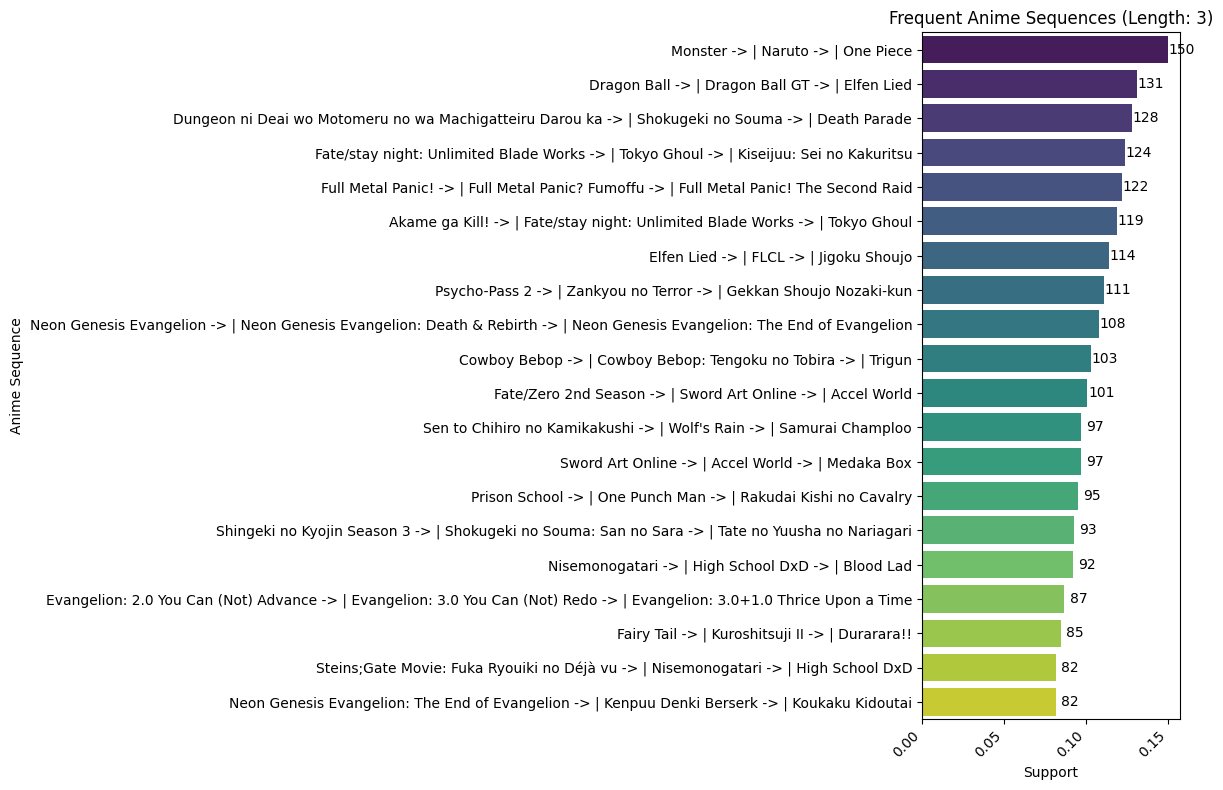

In [36]:
# Create a bar plot of the frequent sequences
plt.figure(figsize=(12, 8))
# Assign a new column for sequence display
frequent_sequences_df['Sequence'] = frequent_sequences_df['Anime Sequence'].apply(lambda x: ' -> | '.join(x))

# Limit the number of sequences displayed if too many
max_sequences_to_display = 20
if len(frequent_sequences_df) > max_sequences_to_display:
    frequent_sequences_df = frequent_sequences_df.head(max_sequences_to_display)

# Create the bar plot
ax = sns.barplot(x='Support', y='Sequence', data=frequent_sequences_df, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the count of the sequence
for i, p in enumerate(ax.patches):
    width = p.get_width()
    sequence_count = frequent_sequences_df.iloc[i]['Count']  # Get count using index i
    ax.annotate(f'{sequence_count:.0f}', (width, p.get_y() + p.get_height() / 2), 
                ha='center', va='center', xytext=(10, 0), 
                textcoords='offset points')

plt.title(f'Frequent Anime Sequences (Length: {sequence_length})')
plt.xlabel('Support')
plt.ylabel('Anime Sequence')
plt.tight_layout()
plt.show()


**Frequent Anime Sequence Result Analysis**

This chart displays the results of sequence pattern mining applied to anime viewing habits. Each bar represents a frequent sequence of three anime series that viewers tend to watch in order. The "Support" value indicates how often this exact sequence appears in the dataset.

1. Pattern discovery: The analysis reveals common viewing patterns among anime fans. For example, the top sequence "Monster -> Naruto -> One Piece" occurred 150 times, indicating a popular viewing order.

2. Viewing behavior insights: These sequences show how viewers transition between different anime series, potentially revealing genre preferences, thematic connections, or viewing trends over time.

3. Franchise engagement: Several sequences contain multiple entries from the same franchise (e.g., Full Metal Panic), showing how viewers engage with entire franchises.

4. Cross-genre exploration: Some sequences mix different genres, providing insights into how viewers diversify their watching habits.

**Importance for anime recommendations:**

1. Personalized suggestions: By analyzing a user's viewing history, a recommendation system can identify which frequent sequences match their pattern and suggest the next anime in that sequence.

2. Content discovery: The system can recommend less obvious connections between anime series based on these frequent sequences, helping users discover new content they might enjoy.

3. Order optimization: Streaming platforms can use this data to optimize the order in which they present series to viewers, potentially increasing engagement.

4. Targeted marketing: Anime distributors can use these patterns to create more effective marketing strategies, promoting related series to the right audience.

5. User experience improvement: Streaming platforms can enhance their user interface by grouping or presenting anime series that frequently appear together in viewing sequences.

6. Predictive analysis: This data can help predict future viewing trends and guide content acquisition decisions for streaming platforms.